# Conditional Generative Adversarial Network (CGAN)

Conditional Generative Adversarial Nets - [Paper](https://arxiv.org/pdf/1411.1784.pdf)

Conditional GANs are constructed by feeding the data we wish to condition on to both the generator and discriminator.

$\min\limits_G\max\limits_D V(D,G) = \mathbb{E}_{x\sim p_{data}(x)} [log D(x|y)] + \mathbb{E}_{z\sim p_z(z)} [log(1 - D(G(z|y)))]$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import tensorflow as tf

def plot_data(X, y):
    """Plot 2D or 3D according to X dimension."""
    if X.shape[1] == 1:
        for i in range(y.shape[1]):
            plt.plot(X, y[:,i], '.')
            plt.show()
    if X.shape[1] == 2:
        for i in range(y.shape[1]):
            ax = plt.axes(projection='3d')
            ax.scatter(X[:,0], X[:,1], y[:,i], c=y[:,i], cmap='viridis')
            plt.show()
            
def get_normal_data(n=1000, plot=False, xy_features=(2,1)):
    """Get normal dataset of x=(n*4,2), y=(n*4,1)."""
    x0 = np.concatenate([
        np.random.normal(10, 2, size=n),
        np.random.normal(10, 2, size=n),
        np.random.normal(20, 2, size=n),
        np.random.normal(20, 2, size=n),
    ])
    x1 = np.concatenate([
        np.random.normal(30, 2, size=n),
        np.random.normal(40, 2, size=n),
        np.random.normal(30, 2, size=n),
        np.random.normal(40, 2, size=n),
    ])
    y = np.concatenate([
        np.random.normal(50, 2, size=n),
        np.random.normal(60, 2, size=n),
        np.random.normal(70, 2, size=n),
        np.random.normal(80, 2, size=n),
    ])
    data = np.stack((x0, x1, y), axis=1).astype(np.float32)
    np.random.shuffle(data)
    
    if plot:
        ax = plt.axes(projection='3d')
        ax.scatter(data[:,0], data[:,1], data[:,2], alpha=0.3, c='r')
        plt.show()
    
    return (data[:,:2], np.expand_dims(data[:,2], axis=1)) \
            if xy_features == (2,1) else \
            (np.expand_dims(data[:,0], axis=1), data[:,1:])

X, y shapes: (4000, 2) (4000, 1)


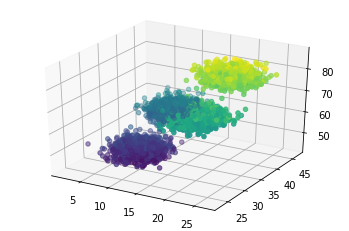

In [2]:
# Use normal dataset
n = 1000
X, y = get_normal_data(n, xy_features=(2,1))
print("X, y shapes:", X.shape, y.shape)

# Plot 2D or 3D graph according to X dimension
plot_data(X, y)

# Convert to TF dataset
n = len(X)
batch_size = 32
dataset = tf.data.Dataset \
    .from_tensor_slices((X,y)) \
    .shuffle(n).batch(batch_size)

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy

class CGAN:
    """Generate y conditioned on x."""
    def __init__(self, x_features, y_features, latent_dim, batch_size=32):
        self.x_features = x_features
        self.y_features = y_features
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.loss = BinaryCrossentropy()
        self.g_optimizer = Adam(1e-4)
        self.d_optimizer = Adam(1e-4)
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.generator.summary()
        self.discriminator.summary()
        
    def build_generator(self):
        noise = Input(shape=(self.latent_dim,))  # noise
        d_noise = Dense(16)(noise)
        x = Input(shape=(self.x_features,))  # condition
        d_x = Dense(16)(x)
        z = Concatenate()([d_noise, d_x])
        d_z = Dense(16)(z)
        y = Dense(self.y_features)(d_z)
        return Model([noise, x], y)
    
    def build_discriminator(self):
        x = Input(shape=(self.x_features))  # condition
        d_x = Dense(16)(x)
        y = Input(shape=(self.y_features))  # y
        d_y = Dense(16)(y)
        h = Concatenate()([d_x, d_y])
        h = Dense(16)(h)
        h = Dropout(0.4)(h)
        p = Dense(1, activation='sigmoid')(h)
        model = Model([y, x], p)
        return model
    
    def g_loss(self, fake_y):
        return self.loss(tf.ones_like(fake_y), fake_y)
    
    def d_loss(self, real_y, fake_y):
        return 0.5 * (self.loss(tf.ones_like(real_y), real_y) + self.loss(tf.zeros_like(fake_y), fake_y))
    
    @tf.function
    def train_step(self, X, real_y):
        noise = tf.random.normal((self.batch_size, self.latent_dim))
        
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            fake_y = self.generator([noise, X], training=True)
            
            real_pred = self.discriminator([real_y, X], training=True)
            fake_pred = self.discriminator([fake_y, X], training=True)
            
            g_loss = self.g_loss(fake_pred)
            d_loss = self.d_loss(real_pred, fake_pred)
            
        g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
        d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))
        return g_loss, d_loss
    
    def fit(self, dataset, epochs=1000):
        g_losses = []
        d_losses = []
        for epoch in range(epochs):
            for X_train, y_train in dataset:
                g_loss, d_loss = self.train_step(X_train, y_train)
                g_losses.append(g_loss)
                d_losses.append(d_loss)
            if epoch % (epochs // 10) == 0:
                print(f"{epoch} [D loss: {d_loss}] [G loss: {g_loss}]")
        plt.plot(g_losses, label='g_loss')
        plt.plot(d_losses, label='d_loss')
        plt.legend(loc='best')
        plt.show()
        
    def sample(self, X):
        noise = np.random.normal(0, 1, (X.shape[0], self.latent_dim)).astype(np.float32)
        return cgan.generator([noise, X]).numpy()

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
input_62 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_120 (Dense)               (None, 16)           272         input_61[0][0]                   
__________________________________________________________________________________________________
dense_121 (Dense)               (None, 16)           48          input_62[0][0]                   
___________________________________________________________________________________________

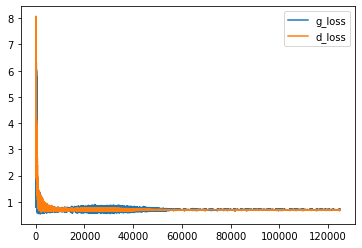

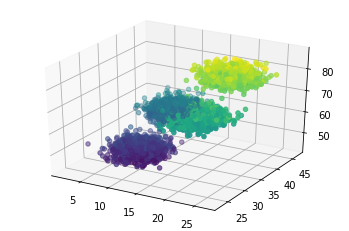

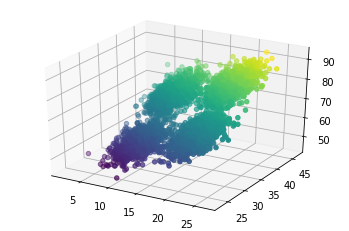

In [30]:
latent_dim=16
cgan = CGAN(x_features=X.shape[1],
            y_features=y.shape[1],
            latent_dim=latent_dim,
            batch_size=batch_size)
cgan.fit(dataset, epochs=1000)
y_hat = cgan.sample(X)

plot_data(X, y)
plot_data(X, y_hat)